# Initializing libraries

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
import lightgbm as lgb

In [145]:
processed_data_dir = Path("../data/processed")

df = pd.read_csv(processed_data_dir / "kzt_exchange_rates_processed_ml.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.dropna(inplace=True)

In [146]:
features = [
    'lag_1', 
    'lag_2', 
    'lag_7',
    'lag_30',
    # 'lag_1_diff', 
    # 'lag_2_diff', 
    # 'lag_7_diff', 
    # 'lag_30_diff',
    'rolling_3', 
    'rolling_7', 
    'rolling_30',
    'weekday_sin', 
    'weekday_cos', 
    'month_sin', 
    'month_cos'
    ]
target = 'exchange_rate'

# Forecasting the current day given the past

In [147]:
X, y = df[features], df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=42)

In [148]:
tscv = TimeSeriesSplit(n_splits=5)

# Support Vector Regression

In [ ]:
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

svr_params = {
    'svr__kernel': ['rbf', 'poly', 'sigmoid'],
    'svr__C': [0.1, 1, 10, 50, 100],
    'svr__epsilon': [0.001, 0.01, 0.1, 0.2],
}

svr_search = RandomizedSearchCV(
    svr_pipe,
    param_distributions=svr_params,
    n_iter=30,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)

svr_search.fit(X_train, y_train)

best_svr = svr_search.best_estimator_
print("Best SVR:", svr_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best SVR: {'svr__kernel': 'poly', 'svr__gamma': 'auto', 'svr__epsilon': 0.01, 'svr__C': 100}


# Random Forest

In [ ]:
rf_pipe = Pipeline([
    ("rf", RandomForestRegressor(random_state=42))
])

rf_params = {
    'rf__n_estimators': [200, 300, 500],
    'rf__max_depth': [5, 10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_params,
    n_iter=25,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    verbose=2,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
print("Best RF:", rf_search.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best RF: {'rf__n_estimators': 500, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_features': None, 'rf__max_depth': 10}


# XGBoost

In [ ]:
xgb = XGBRegressor(random_state=42)
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb_search = RandomizedSearchCV(
    xgb,
    param_distributions=xgb_params,
    n_iter=50,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)
xgb_search.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_
print("Best XGBoost:", xgb_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


# Performance on train set

In [157]:
models = {
    "SVR": best_svr,
    "RandomForest": best_rf,
    "XGBoost": best_xgb
}

for name, model in models.items():
    pred = model.predict(X_train)

    mae = mean_absolute_error(y_train, pred)
    rmse = np.sqrt(mean_squared_error(y_train, pred))
    print(f"{name} - Train MAE: {mae:.4f}, RMSE: {rmse:.4f}")

SVR - Train MAE: 1.8277, RMSE: 3.1116
RandomForest - Train MAE: 1.2228, RMSE: 1.9039
XGBoost - Train MAE: 1.7883, RMSE: 2.7556


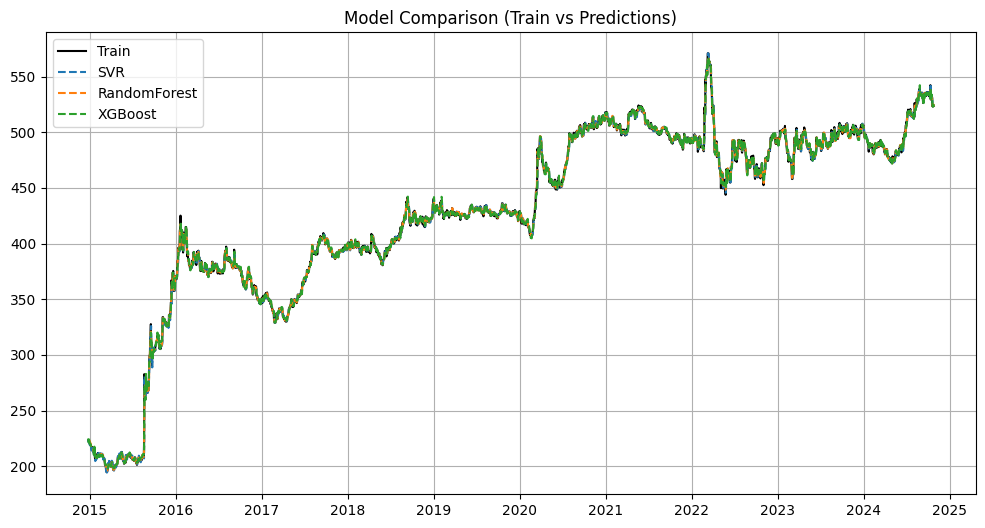

In [158]:
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train', color='black')

for name, model in models.items():
    preds = model.predict(X_train)

    plt.plot(y_train.index, preds, label=name, linestyle='--')
plt.title("Model Comparison (Train vs Predictions)")
plt.legend()
plt.grid()
plt.show()

# Performance on test set

In [159]:
models = {
    "SVR": best_svr,
    "RandomForest": best_rf,
    "XGBoost": best_xgb
}

for name, model in models.items():
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    
    print(f"\n{name} Results:")
    print(f" MAE:  {mae:.4f}")
    print(f" RMSE: {rmse:.4f}")



SVR Results:
 MAE:  3.0584
 RMSE: 4.0752

RandomForest Results:
 MAE:  33.2846
 RMSE: 44.5061

XGBoost Results:
 MAE:  36.9026
 RMSE: 49.1336


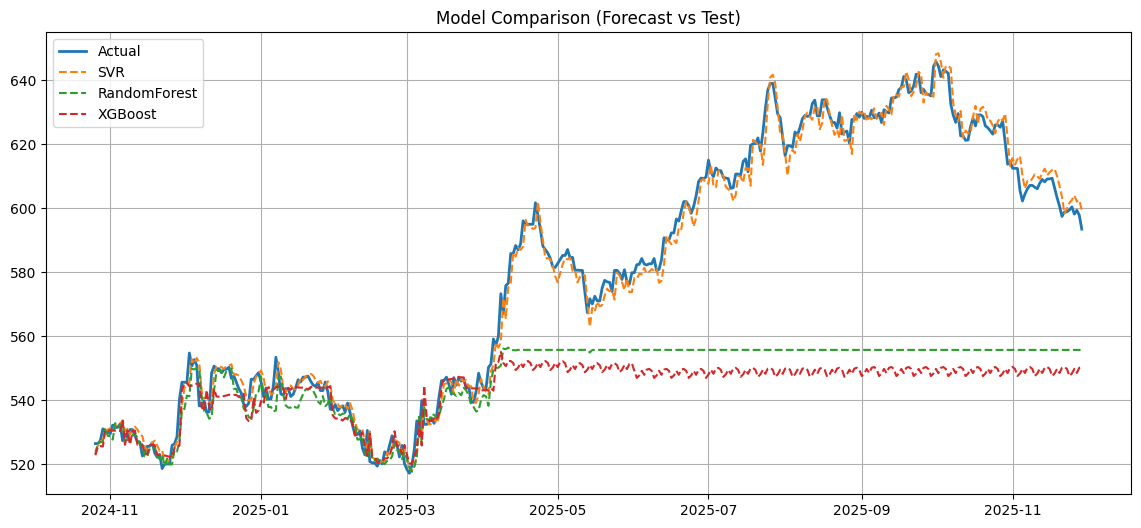

In [160]:
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)

for name, model in models.items():
    preds = model.predict(X_test)

    plt.plot(y_test.index, preds, label=name, linestyle='--')

plt.title("Model Comparison (Forecast vs Test)")
plt.legend()
plt.grid()
plt.show()


# Performance on the first 30% of the test set (for validating the hypothesis from the paper)

In [161]:
models = {
    "SVR": best_svr,
    "RandomForest": best_rf,
    "XGBoost": best_xgb
}

for name, model in models.items():
    pred = model.predict(X_test)

    turning_point = int(len(pred) * 0.3)

    mae = mean_absolute_error(y_test.iloc[:turning_point], pred[:turning_point])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:turning_point], pred[:turning_point]))
    
    print(f"\n{name} Results:")
    print(f" MAE:  {mae:.4f}")
    print(f" RMSE: {rmse:.4f}")



SVR Results:
 MAE:  2.6525
 RMSE: 3.6922

RandomForest Results:
 MAE:  3.4118
 RMSE: 4.6971

XGBoost Results:
 MAE:  3.5025
 RMSE: 4.6935
